In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
import hashlib
import re
from typing import Tuple

from src.debate.types import DebateScenario


def get_id(text: str) -> str:
    """Get the unique ID for the scenario."""
    return hashlib.md5(text.encode()).hexdigest()


def split_question(example: str) -> Tuple[str, str]:
    """Split the example text into the game and the question."""
    example_text = example
    question = re.split(r"\.\s+", example_text)[-1]
    game = example_text.replace(question, "").strip()
    return game, question


def convert_to_scenarios(examples: list) -> list[DebateScenario]:
    """Convert BoardgameQA examples to DebateScenario objects."""

    scenarios = []
    for ex in examples:
        situation, question = split_question(ex["example"])
        scenario = DebateScenario(
            id=get_id(ex["example"]),
            situation=situation,
            question=question,
            answer_options=["proved", "disproved", "unknown"],
            label=ex["label"],
            level=ex["level"],
        )
        scenarios.append(scenario)
    return scenarios

# Open the list of data

In [3]:
import json
from typing import Dict

LEVELS = ["LowConflict", "HighConflict"]
scenarios: Dict[str, DebateScenario] = {}
scenario_list = []

with open("../data/sampled_boardgame_qa.jsonl") as f:
    for line in f.readlines():
        data = json.loads(line)
        if data["level"] in LEVELS:
            scenario = convert_to_scenarios([data])
            scenarios[scenario[0].id] = scenario[0]
            scenario_list.append(scenario[0])

print(f"Number of scenarios: {len(scenarios)}")

Number of scenarios: 120


# Open the records

In [4]:
from pathlib import Path

result_path = Path("../results/self-play-claude-3.5-haiku")
baseline_batch_path = sorted(result_path.glob("baseline_*.json"))
debates_batch_path = sorted(result_path.glob("debates_*.json"))
judgements_batch_path = sorted(result_path.glob("judgments_*.json"))

print("Number of batch:")
print(f"  - baselines: {len(baseline_batch_path)}")
print(f"  - debates: {len(debates_batch_path)}")
print(f"  - judgements: {len(judgements_batch_path)}")

Number of batch:
  - baselines: 24
  - debates: 24
  - judgements: 24


In [5]:
from dotenv import load_dotenv

load_dotenv()

from langfuse import Langfuse

lf = Langfuse(
    host=os.getenv("LANGFUSE_HOST"),
    public_key=os.getenv("LANGFUSE_PUBLIC_KEY"),
    secret_key=os.getenv("LANGFUSE_SECRET_KEY"),
)


def get_situation_question(text: str) -> str:
    """Split the example text into the game and the question."""
    situation = re.findall("<situation>(.*?)</situation>", text, re.DOTALL)[0].strip()
    question = re.findall("<question>(.*?)</question>", text, re.DOTALL)[0].strip()
    return f"{situation} {question}"


def get_scenario_id(baseline_dict: dict) -> str:
    """Get the scenario ID from the baseline dictionary."""
    traces = lf.fetch_traces(user_id=baseline_dict["id"]).data
    if traces:
        if observatio_ids := traces[0].observations:
            for observation_id in observatio_ids:
                observations = lf.fetch_observation(observation_id).data
                contents = [obs["content"] for obs in observations.input]
                sq = get_situation_question("\n".join(contents))
                scenario_id = get_id(sq)
                if scenario_id in scenarios:
                    return scenario_id

In [6]:
MODEL_NAME = "claude-3.5-haiku"
scenario2record = {}  # key: scenario_id, value: list of record_id
baseline_records = {}  # key: scenario_id, value: list of baseline records
debate_records = {}  # key: record_id, value: debate record
judge_records = {}  # key: record_id, value: judgement record

baseline_count = 0
problematic_baseline = []

for i in range(len(baseline_batch_path)):
    with open(baseline_batch_path[i]) as f:
        baseline_ = json.load(f)
        baseline_ = list(baseline_.values())[0]
    with open(debates_batch_path[i]) as f:
        debates_ = json.load(f)
    with open(judgements_batch_path[i]) as f:
        judgements_ = json.load(f)
        judgements_ = list(judgements_.values())[0]

    print(f"\nBatch {i}")
    print(f"  - Number of baselines: {len(baseline_)}")
    print(f"  - Number of debates: {len(debates_)}")
    print(f"  - Number of judgements: {len(judgements_)}")

    scenario_this_batch = {}

    for debate in debates_:
        record_id = debate["id"]
        situation = debate["scenario"]["situation"]
        question = debate["scenario"]["question"]
        scenario_id = get_id(f"{situation} {question}")
        if scenario_id not in scenario2record:
            scenario2record[scenario_id] = []
        scenario2record[scenario_id].append(record_id)
        scenario = debate.pop("scenario")
        scenario_this_batch[scenario_id] = scenario

        debate.pop("id")
        debate_records[record_id] = debate

    for judgement in judgements_:
        record_id = judgement["id"]
        judgement.pop("id")
        judge_records[record_id] = judgement

    for baseline in baseline_:
        scenario_id = get_scenario_id(baseline)
        if scenario_id:
            baseline_records[scenario_id] = baseline
        else:
            print(f"Baseline {baseline['id']} not found")
            problematic_baseline.append(baseline)
            baseline_records[baseline["id"]] = baseline


print(f"Number of scenarios : {len(scenario2record)}")
print(f"Number of baselines : {len(baseline_records)}")
print(f"Number of debates   : {len(debate_records)}")
print(f"Number of judgements: {len(judge_records)}")
print(f"Number of problematic baselines: {len(problematic_baseline)}")


Batch 0
  - Number of baselines: 5
  - Number of debates: 15
  - Number of judgements: 15
Baseline 501c4796-c911-4b69-9486-9789d63db40a not found

Batch 1
  - Number of baselines: 5
  - Number of debates: 15
  - Number of judgements: 15
Baseline 7597301a-010c-478b-ae5d-bfc91b581d24 not found

Batch 2
  - Number of baselines: 5
  - Number of debates: 15
  - Number of judgements: 15
Baseline ad786668-ecc0-46c0-81c9-e91546caaf72 not found

Batch 3
  - Number of baselines: 5
  - Number of debates: 15
  - Number of judgements: 15
Baseline 43133445-18e9-4b6d-b07b-7efcb923f6c6 not found

Batch 4
  - Number of baselines: 5
  - Number of debates: 15
  - Number of judgements: 15
Baseline 13a5d9b2-7c3f-46c7-a0e8-58c10ad99f5e not found
Baseline 91221e5f-b165-4eff-bda0-546c1b79e176 not found

Batch 5
  - Number of baselines: 5
  - Number of debates: 15
  - Number of judgements: 15
Baseline 265f7a60-5ef1-465e-b5a1-e7eb490d9531 not found

Batch 6
  - Number of baselines: 5
  - Number of debates: 15


In [7]:
record2scenario = {rec: sce for sce, recs in scenario2record.items() for rec in recs}
len(record2scenario)

360

In [8]:
# Get the line of the baseline judgement
for problem in problematic_baseline:
    print(problem["id"])
    print(problem["judgment"].split("\n")[4][2:])
    print()

501c4796-c911-4b69-9486-9789d63db40a
The bulldog is watching a movie from 1907

7597301a-010c-478b-ae5d-bfc91b581d24
The fangtooth is watching a movie from 1955

ad786668-ecc0-46c0-81c9-e91546caaf72
The dinosaur convinces the owl

43133445-18e9-4b6d-b07b-7efcb923f6c6
The songbird creates one castle for the rhino

13a5d9b2-7c3f-46c7-a0e8-58c10ad99f5e
The monkey (Max) has 90 dollars

91221e5f-b165-4eff-bda0-546c1b79e176
The wolf has a red card

265f7a60-5ef1-465e-b5a1-e7eb490d9531
The dove has 50 dollars

5921bb0c-a660-4cec-be4f-9be79a2b56e6
Chinchilla is named Lucy

bbe13940-8f48-45cf-83e0-49469f136dcc
Cobra is named Milo

6e0e30ff-d919-4987-9ef2-aebca4d13120
The pelikan has 74 dollars

5ae584ef-b1d8-4df5-b39f-f36a12b67d49
The elk swims in the pool next to the chinchilla's house

2e673cbb-2244-4cfe-88bf-b4921d7ec2cb
The bear is named Luna

1a2fca77-a40a-4e10-9d4a-fcbe9acab56f
The llama has an orange card

7c5461d9-a745-4a73-a6b0-625be652251c
The elk has a harmonica

d1e84ca0-06c3-4a89-b

In [9]:
# Sanity check
record_id = "3f793ccb-10e5-460e-bdd6-0856e95e4593"
record2scenario[record_id] not in baseline_records, record2scenario[record_id]

(True, 'eced42550a1f6fa49707c6e533fe0d44')

In [10]:
mapping = {
    "501c4796-c911-4b69-9486-9789d63db40a": "7dd4de9db2892178fa5ba47472c1f7a7",
    "7597301a-010c-478b-ae5d-bfc91b581d24": "c247d28bdedf9d10a7fdb548601c5c3f",
    "ad786668-ecc0-46c0-81c9-e91546caaf72": "2a3fd7fc41048b87ae847b1c2b213eaa",
    "43133445-18e9-4b6d-b07b-7efcb923f6c6": "51f04d6ac1cea47bf917fcea1d8cf3fd",
    "13a5d9b2-7c3f-46c7-a0e8-58c10ad99f5e": "915eb90d8c288df52e74c292fb9bef96",
    "91221e5f-b165-4eff-bda0-546c1b79e176": "bccc6fc66c08f1d61545c53acb8a20a7",
    "265f7a60-5ef1-465e-b5a1-e7eb490d9531": "cc30a2570cb8a12ccc629c3c3f94a6c3",
    "5921bb0c-a660-4cec-be4f-9be79a2b56e6": "bbefdeb0c4de615da9b165d2c160a818",
    "bbe13940-8f48-45cf-83e0-49469f136dcc": "da389cc894015ed6374554c62b334646",
    "6e0e30ff-d919-4987-9ef2-aebca4d13120": "16ac3e4888cba4553fc8aaaf002e1fb0",
    "5ae584ef-b1d8-4df5-b39f-f36a12b67d49": "d49c88a215021df70dafb455b0d8a49b",
    "2e673cbb-2244-4cfe-88bf-b4921d7ec2cb": "868248929d9028b28a3adb63271b484f",
    "1a2fca77-a40a-4e10-9d4a-fcbe9acab56f": "54b86326729f3697f5e9e4e2956aa867",
    "7c5461d9-a745-4a73-a6b0-625be652251c": "5a403b90860db9e409dcf80db7d2d3f2",
    "d1e84ca0-06c3-4a89-bd18-f8d057056f05": "a0bfb87225bc8b97730f23c978fbbc71",
    "84511c6b-a9a5-44d1-9398-f6df412161d8": "68fb90f6350de4b804c1c1dad37fe85e",
    "c5f06d36-cb31-4e20-92cf-bd8abdb9809a": "c5608d220836d96e64609d843f61f30c",
    "5a3f06c9-8072-4c15-ae0f-161b082602fc": "2d5795e57ded035e4358dbf645b410f2",
    "6c70266f-b43e-4e45-b963-36b3359cd059": "3ace07a009ef259c33ef3dacd82a2fcb",
    "3980d31e-b368-4c94-9938-6eb604dd39c8": "6cfda29cce95e99b8557b02a7329a2d7",
    "a4916c0b-74df-4783-808e-649190de6376": "09000c3d82cda08090f3527f6ace6ce4",
    "bb5a4af8-b279-42e2-a3f7-86e9818e10f8": "78771f21f888ff8325a1fa4d20a11898",
    "cb513a05-ba9b-41a1-bc64-1857a7c6f6e4": "7ca0a3144173fa83e8cf10035fd4c1bb",
    "15b8e1ce-a424-48cf-a4ec-b182ede0ee8c": "8eec006866fa99193f94453de6540673",
    "2104fb5f-c9a6-4913-ab5c-c5d530505d7c": "eced42550a1f6fa49707c6e533fe0d44",
}


# Replace the key in the baseline records with the correct scenario ID
copy_baseline_records = baseline_records.copy()
for key, value in copy_baseline_records.items():
    if key in mapping:
        baseline_records[mapping[key]] = value
        del baseline_records[key]
        print(f"Replace {key} with {mapping[key]}")

Replace 501c4796-c911-4b69-9486-9789d63db40a with 7dd4de9db2892178fa5ba47472c1f7a7
Replace 7597301a-010c-478b-ae5d-bfc91b581d24 with c247d28bdedf9d10a7fdb548601c5c3f
Replace ad786668-ecc0-46c0-81c9-e91546caaf72 with 2a3fd7fc41048b87ae847b1c2b213eaa
Replace 43133445-18e9-4b6d-b07b-7efcb923f6c6 with 51f04d6ac1cea47bf917fcea1d8cf3fd
Replace 13a5d9b2-7c3f-46c7-a0e8-58c10ad99f5e with 915eb90d8c288df52e74c292fb9bef96
Replace 91221e5f-b165-4eff-bda0-546c1b79e176 with bccc6fc66c08f1d61545c53acb8a20a7
Replace 265f7a60-5ef1-465e-b5a1-e7eb490d9531 with cc30a2570cb8a12ccc629c3c3f94a6c3
Replace 5921bb0c-a660-4cec-be4f-9be79a2b56e6 with bbefdeb0c4de615da9b165d2c160a818
Replace bbe13940-8f48-45cf-83e0-49469f136dcc with da389cc894015ed6374554c62b334646
Replace 6e0e30ff-d919-4987-9ef2-aebca4d13120 with 16ac3e4888cba4553fc8aaaf002e1fb0
Replace 5ae584ef-b1d8-4df5-b39f-f36a12b67d49 with d49c88a215021df70dafb455b0d8a49b
Replace 2e673cbb-2244-4cfe-88bf-b4921d7ec2cb with 868248929d9028b28a3adb63271b484f
Repl

In [11]:
# Check if all the baseline records are in the scenario2record
for key in baseline_records.keys():
    if key not in scenario2record:
        print(f"{key} not in scenario2record")
    if key not in scenarios:
        print(f"{key} not in scenarios")

In [12]:
# Check if debates and judgements are consistent
for scenario_id in scenario2record:
    for record_id in scenario2record[scenario_id]:
        if record_id not in debate_records:
            print(f"Missing debate record: {record_id}")
        if record_id not in judge_records:
            print(f"Missing judgement record: {record_id}")

In [13]:
# Check if scenarios are consistent
for scenario_id in scenarios:
    if scenario_id not in scenario2record:
        print(f"Missing scenario: {scenario_id}")

# Extract judge model answers

In [349]:
from typing import Literal

import pandas as pd

from src.debate.types import DebateRecord, DebaterNames


def get_answer(text: str) -> Literal["A", "B", "C"]:
    """Get the answer from the text."""
    answer = re.findall(r"Answer: (A|B|C)", text)
    if answer:
        return answer[0]
    answer = re.findall(r"Answer: <(A|B|C)>", text)
    if answer:
        return answer[0]
    return "invalid"


def answer_to_label(answer: Literal["A", "B", "C"]) -> str:
    """Convert the answer to label."""
    if answer == "A":
        return "proved"
    elif answer == "B":
        return "disproved"
    elif answer == "C":
        return "unknown"
    return "invalid"


def get_num_correct_quote(text: str) -> int:
    """Get the number of correct quote from the text."""
    pattern = re.compile(r"<v_quote>(.*?)</v_quote>")
    return len(re.findall(pattern, text))


def get_num_incorrect_quote(text: str) -> int:
    """Get the number of incorrect quote from the text."""
    pattern = re.compile(r"<u_quote>(.*?)</u_quote>")
    return len(re.findall(pattern, text))


answers = []

for scenario_id, scenario in scenarios.items():
    baseline_judgement = baseline_records[scenario_id]["judgment"]
    baseline_answer = answer_to_label(get_answer(baseline_judgement))
    for record_id in scenario2record[scenario_id]:
        debate = DebateRecord(scenario=scenario, **debate_records[record_id])

        correct_debater_pos: Literal[1, 2, -1] = -1
        if debate.debater_positions[DebaterNames.A.value] == scenario.label:
            correct_debater_pos = 1
        elif debate.debater_positions[DebaterNames.B.value] == scenario.label:
            correct_debater_pos = 2

        # Get the number of validated quote from each debater argument
        debater_a_args = ""
        debater_b_args = ""
        for t in debate.transcript:
            if t["name"] == DebaterNames.A.value:
                debater_a_args += t["validated_response_arguments"]
            elif t["name"] == DebaterNames.B.value:
                debater_b_args += t["validated_response_arguments"]

        num_correct_quote_a = get_num_correct_quote(debater_a_args)
        num_correct_quote_b = get_num_correct_quote(debater_b_args)
        num_incorrect_quote_a = get_num_incorrect_quote(debater_a_args)
        num_incorrect_quote_b = get_num_incorrect_quote(debater_b_args)
        debater_a_quote_acc = num_correct_quote_a / (
            num_correct_quote_a + num_incorrect_quote_a
        )
        debater_b_quote_acc = num_correct_quote_b / (
            num_correct_quote_b + num_incorrect_quote_b
        )

        # Get the judge answer
        judge_judgement = judge_records[record_id]["judgment"]
        judge_chosen_debater = get_answer(judge_judgement)
        if judge_chosen_debater == "invalid":
            print(f"Invalid answer for record {record_id}")
            print(judge_judgement)
            continue
        chosen_debater_name = getattr(DebaterNames, judge_chosen_debater)
        judge_answer = debate.debater_positions[chosen_debater_name.value]

        # Get the accuracy of the chosen debater
        chosen_debater_quote_acc = 0
        other_debater_quote_acc = 0
        if chosen_debater_name == DebaterNames.A:
            chosen_debater_quote_acc = debater_a_quote_acc
            other_debater_quote_acc = debater_b_quote_acc
        elif chosen_debater_name == DebaterNames.B:
            chosen_debater_quote_acc = debater_b_quote_acc
            other_debater_quote_acc = debater_a_quote_acc
        chosen_debater_quote_acc_diff = (
            chosen_debater_quote_acc - other_debater_quote_acc
        )

        answers.append(
            {
                "scenario_id": scenario_id,
                "record_id": record_id,
                "level": scenario.level,
                "correct_debater_pos": correct_debater_pos,
                "label": scenario.label,
                "baseline": baseline_answer,
                "judge": judge_answer,
                "chosen_debater": 1 if chosen_debater_name == DebaterNames.A else 2,
                "a_quote_acc": debater_a_quote_acc,
                "a_quote_num": (num_correct_quote_a + num_incorrect_quote_a),
                "b_quote_acc": debater_b_quote_acc,
                "b_quote_num": (num_correct_quote_b + num_incorrect_quote_b),
                "chosen_debater_quote_acc_diff": chosen_debater_quote_acc_diff,
            }
        )

answers_df = pd.DataFrame.from_dict(answers)
answers_df.sample(2)

,scenario_id,record_id,level,correct_debater_pos,label,baseline,judge,chosen_debater,a_quote_acc,a_quote_num,b_quote_acc,b_quote_num,chosen_debater_quote_acc_diff
94,c95517e7411df76a6c97a5c5307f4f23,3770e84c-e1d2-41ef-ad42-1f29b08980ea,LowConflict,2,disproved,disproved,disproved,2,0.833333,6,1.0,7,0.166667
257,93b69fd0054fbb398f5f21617b25c2bc,104f5a6e-9897-40f6-a87f-19681649467c,HighConflict,-1,disproved,unknown,proved,2,0.777778,9,1.0,8,0.222222


In [350]:
import numpy as np

answers_df["Baseline Correct"] = np.where(
    answers_df["label"] == answers_df["baseline"], 1, 0
)
answers_df["Judge Correct"] = np.where(answers_df["label"] == answers_df["judge"], 1, 0)
answers_df.sample(2)

,scenario_id,record_id,level,correct_debater_pos,label,baseline,judge,chosen_debater,a_quote_acc,a_quote_num,b_quote_acc,b_quote_num,chosen_debater_quote_acc_diff,Baseline Correct,Judge Correct
254,16ac3e4888cba4553fc8aaaf002e1fb0,1fd44971-9147-461b-8174-f8a021edd9dd,HighConflict,-1,disproved,disproved,proved,2,0.333333,9,0.8,10,0.466667,1,0
44,5a403b90860db9e409dcf80db7d2d3f2,71c0e146-eca2-4218-9538-cb89bf53a66d,LowConflict,-1,proved,proved,unknown,2,0.714286,7,1.0,7,0.285714,1,0


In [351]:
answers_df.to_csv(result_path / "results.csv", index=False)

# Analysis

In [352]:
answers_df = pd.read_csv(result_path / "results.csv")

In [353]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(style="whitegrid", palette="colorblind")

## Fundamental Effectiveness

### Does the debate process improve accuracy compared to baseline direct answers?

In [354]:
from scipy import stats

# Calculate accuracy

baseline_correct = answers_df["Baseline Correct"].sum()
judge_correct = answers_df["Judge Correct"].sum()
total = len(answers_df)

baseline_accuracy = baseline_correct / total
judge_accuracy = judge_correct / total

print(f"Baseline Accuracy: {baseline_accuracy:.2%}")
print(f"Judge Accuracy: {judge_accuracy:.2%}")

if baseline_accuracy > judge_accuracy:
    print("Baseline is better")
else:
    print("Judge is better")


Baseline Accuracy: 45.83%
Judge Accuracy: 39.44%
Baseline is better


In [355]:
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar


def test_debate_effectiveness(answers_df):
    # Create contingency table for McNemar's test
    # Both correct (1,1), baseline wrong & judge right (0,1),
    # baseline right & judge wrong (1,0), both wrong (0,0)
    contingency = pd.crosstab(
        answers_df["baseline"] == answers_df["label"],
        answers_df["judge"] == answers_df["label"],
    )
    r = mcnemar(contingency)
    odds_ratio = contingency.iloc[1, 0] / contingency.iloc[0, 1]

    print("McNemar's Test Results:")
    print(f"Statistic: {r.statistic:.3f}")
    print(f"P-value: {r.pvalue:.3f}")
    print(f"Odds ratio: {odds_ratio:.3f}")

    return r.statistic, r.pvalue, odds_ratio


stat, p_val, ratio = test_debate_effectiveness(answers_df)
print(f"Statistic: {stat:.3f}")
print(f"P-value: {p_val:.3f}")
print(f"Odds ratio: {ratio:.3f}")
if p_val < 0.05:
    print("Reject null hypothesis: Baseline and judge have different effectiveness")
else:
    print(
        "Fail to reject null hypothesis: Baseline and judge have similar effectiveness"
    )


McNemar's Test Results:
Statistic: 66.000
P-value: 0.077
Odds ratio: 1.348
Statistic: 66.000
P-value: 0.077
Odds ratio: 1.348
Fail to reject null hypothesis: Baseline and judge have similar effectiveness


### How does performance vary across different levels of information conflict?

In [356]:
# Break down by level
level_results = answers_df.groupby("level", as_index=False).agg(
    Count=("level", "count"),
    Baseline=("Baseline Correct", "mean"),
    Judge=("Judge Correct", "mean"),
)
level_results["Accuracy Gain"] = level_results["Judge"] - level_results["Baseline"]

print("\nAccuracy by level:")
print(level_results.to_string(index=False))


Accuracy by level:
       level  Count  Baseline    Judge  Accuracy Gain
HighConflict    180  0.383333 0.383333       0.000000
 LowConflict    180  0.533333 0.405556      -0.127778


In [ ]:
# Remove Position -1
correct_exist_df = answers_df[answers_df["correct_debater_pos"] != -1]
nneg_level_results = correct_exist_df.groupby("level", as_index=False).agg(
    Count=("level", "count"),
    Baseline=("Baseline Correct", "mean"),
    Judge=("Judge Correct", "mean"),
)
nneg_level_results["Accuracy Gain"] = (
    nneg_level_results["Judge"] - nneg_level_results["Baseline"]
)
print("\nAccuracy by level (excluding 'No Correct Debater' setup):")
print(nneg_level_results.to_string(index=False))



Accuracy by level (excluding 'No Correct Debater' setup):
       level  Count  Baseline    Judge  Accuracy Gain
HighConflict    120  0.383333 0.575000       0.191667
 LowConflict    120  0.533333 0.608333       0.075000


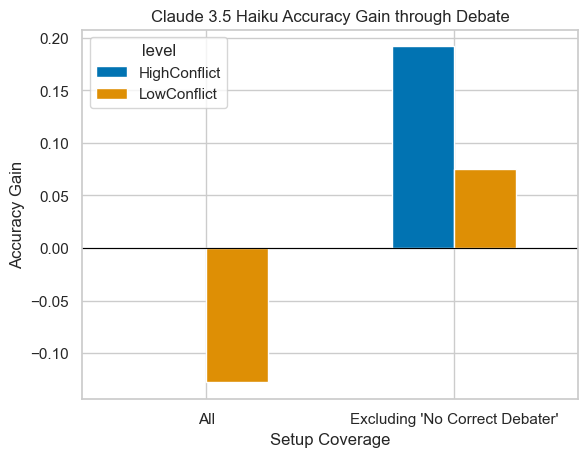

In [367]:
# Join the two dataframes then plot
answers_df_ = answers_df.copy()
answers_df_["Setup Coverage"] = "All"
correct_exist_df_ = correct_exist_df.copy()
correct_exist_df_["Setup Coverage"] = "Excluding 'No Correct Debater'"
merged_answers_df = pd.concat([answers_df_, correct_exist_df_])
# Plot the baseline and judge accuracy by level while comparing between protocol (hue)
merged_results = merged_answers_df.groupby(
    ["Setup Coverage", "level"], as_index=False
).agg(
    Baseline=("Baseline Correct", "mean"),
    Judge=("Judge Correct", "mean"),
)
merged_results["Accuracy Gain"] = merged_results["Judge"] - merged_results["Baseline"]

# Plot the accuracy gain
merged_results.pivot(
    index="Setup Coverage", columns="level", values="Accuracy Gain"
).plot(
    kind="bar",
    # figsize=(10, 4),
    title="Claude 3.5 Haiku Accuracy Gain through Debate",
    # ylim=(-0.5, 0.5),
    ylabel="Accuracy Gain",
    rot=0,
)
plt.axhline(0, color="black", linewidth=0.8)
plt.show()


Looking at the full setup (including "No Correct Debater"):
- High Conflict: NO improvement from baseline (0.383 → 0.383, gain = 0)
- Low Conflict: Actually WORSE than baseline (0.533 → 0.406, loss of 0.128)

But when we exclude "No Correct Debater" cases:
- High Conflict: Substantial IMPROVEMENT (0.383 → 0.575, gain of 0.192)
- Low Conflict: Modest improvement (0.533 → 0.608, gain of 0.075)

This is quite revealing! Including the "No Correct Debater" setup is actually masking the real effectiveness of the debate process. When we focus only on cases where at least one debater has the correct answer, the debate system shows clear improvements over baseline, especially in high conflict scenarios.

Particularly striking is the high conflict case - the debate process appears to be most valuable precisely when there are conflicting rules or information, showing a substantial 19.2 percentage point improvement. This suggests the debate format is doing what we want it to do: helping clarify complex, conflicting situations.

For the rest of the analysis, we should definitely exclude the "No Correct Debater" setup. Including it:
1. Masks the true effectiveness of the debate process
2. Artificially deflates performance metrics
3. Doesn't represent the intended use case (in real applications, we'd want at least one debater to have access to the truth)

While the "No Correct Debater" setup was an interesting experimental condition, it's served its purpose in showing that the judge consistently fails when neither debater has the truth (as we'd hope). For understanding and improving the debate system's effectiveness, we should focus on the cases where truth is available to at least one debater.

In [359]:
# Let's do the statistical test again
stat, p_val, ratio = test_debate_effectiveness(correct_exist_df)
print(f"Statistic: {stat:.3f}")
print(f"P-value: {p_val:.3f}")
print(f"Odds ratio: {ratio:.3f}")
if p_val < 0.05:
    print("Reject null hypothesis: Baseline and judge have different effectiveness")
else:
    print(
        "Fail to reject null hypothesis: Baseline and judge have similar effectiveness"
    )


McNemar's Test Results:
Statistic: 34.000
P-value: 0.002
Odds ratio: 0.515
Statistic: 34.000
P-value: 0.002
Odds ratio: 0.515
Reject null hypothesis: Baseline and judge have different effectiveness


## Structural Biases

### Is there a systematic advantage to arguing first or second in the debate?

<Axes: title={'center': 'Chosen Debater by Level'}, xlabel='Chosen Debater', ylabel='Count'>

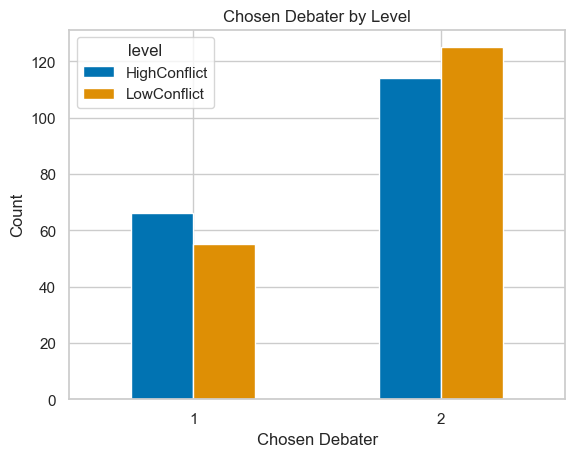

In [368]:
chosen_debater_counts = (
    answers_df.groupby(["chosen_debater", "level", ""]).size().unstack()
)
chosen_debater_counts.plot(
    kind="bar",
    title="Chosen Debater by Level",
    rot=0,
    ylabel="Count",
    xlabel="Chosen Debater",
)


Overall position distribution:
 correct_debater_pos Judge Correct  Count  Percentage
                   1     Incorrect     65    0.270833
                   1       Correct     55    0.229167
                   2     Incorrect     33    0.137500
                   2       Correct     87    0.362500


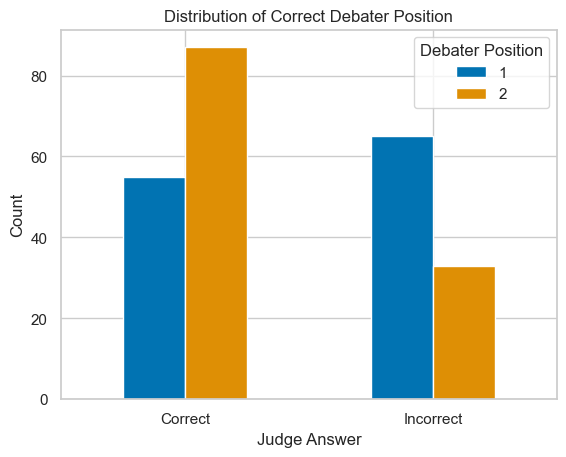

In [ ]:
# Calculate overall position bias
position_counts = correct_exist_df.groupby(
    ["correct_debater_pos", "Judge Correct"], as_index=False
).agg(Count=("correct_debater_pos", "count"))
position_counts["Percentage"] = position_counts["Count"] / len(correct_exist_df)
position_counts["Judge Correct"] = position_counts["Judge Correct"].map(
    {0: "Incorrect", 1: "Correct"}
)

print("\nOverall position distribution:")
print(position_counts.to_string(index=False))

position_counts.pivot(
    index="Judge Correct", columns="correct_debater_pos", values="Count"
).plot(
    kind="bar",
    # figsize=(10, 6),
    title="Distribution of Correct Debater Position",
    rot=0,
    ylabel="Count",
    xlabel="Judge Answer",
)
plt.legend(title="Debater Position")
plt.show()


Accuracy by correct debater position:
 correct_debater_pos  Count  Baseline    Judge  Accuracy Gain
                   1    120  0.458333 0.458333       0.000000
                   2    120  0.458333 0.725000       0.266667


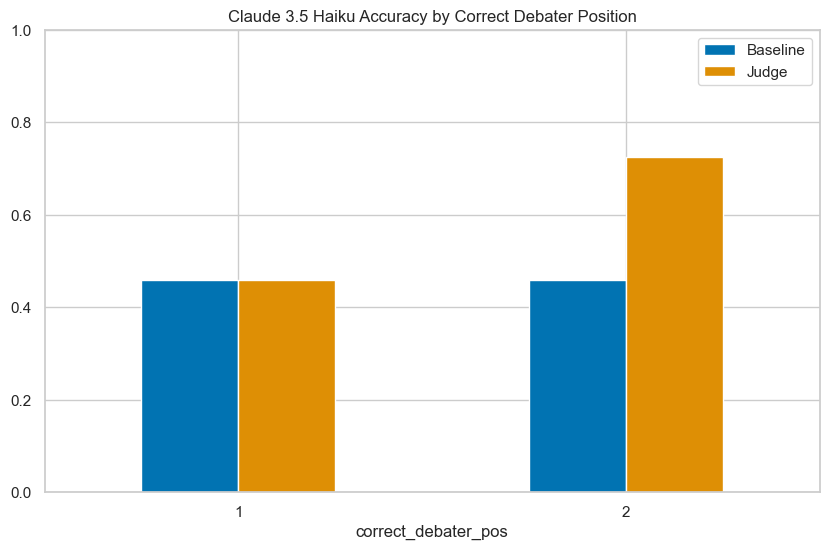

<Axes: title={'center': 'Claude 3.5 Haiku Accuracy Gain by Correct Debater Position'}, xlabel='level,correct_debater_pos'>

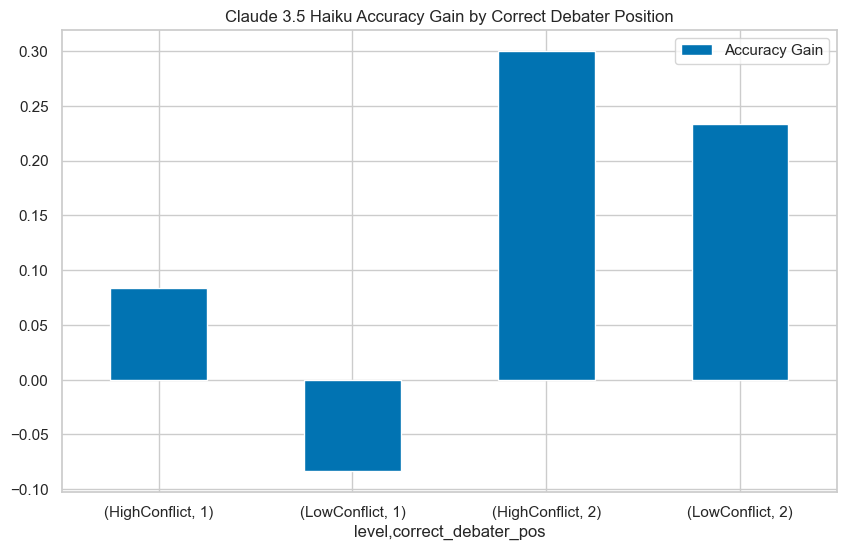

In [325]:
# Break down by correct debater position and accuracy gain based on the baseline
correct_debater_results = correct_exist_df.groupby(
    ["correct_debater_pos"], as_index=False
).agg(
    Count=("correct_debater_pos", "count"),
    Baseline=("Baseline Correct", "mean"),
    Judge=("Judge Correct", "mean"),
)
correct_debater_results["Accuracy Gain"] = (
    correct_debater_results["Judge"] - correct_debater_results["Baseline"]
)

print("\nAccuracy by correct debater position:")
print(correct_debater_results.to_string(index=False))

correct_debater_results.plot(
    x="correct_debater_pos",
    y=["Baseline", "Judge"],
    kind="bar",
    figsize=(10, 6),
    title="Claude 3.5 Haiku Accuracy by Correct Debater Position",
    rot=0,
)
plt.ylim(0, 1)
plt.show()

# Plot again but comparing between level
correct_debater_results_ = correct_exist_df.groupby(
    ["correct_debater_pos", "level"], as_index=False
).agg(
    Count=("correct_debater_pos", "count"),
    Baseline=("Baseline Correct", "mean"),
    Judge=("Judge Correct", "mean"),
)
correct_debater_results_["Accuracy Gain"] = (
    correct_debater_results_["Judge"] - correct_debater_results_["Baseline"]
)
correct_debater_results_.set_index(
    [
        "level",
        "correct_debater_pos",
    ]
).plot(
    # x="correct_debater_pos",
    y="Accuracy Gain",
    kind="bar",
    figsize=(10, 6),
    title="Claude 3.5 Haiku Accuracy Gain by Correct Debater Position",
    rot=0,
)

#### Testing for position bias

In [159]:
alpha = 0.05
print(f"\nSignificance level: {alpha}")

for level in answers_df["level"].unique():
    level_data = answers_df[answers_df["level"] == level]

    # Create contingency table for debater position vs judge accuracy
    contingency = pd.crosstab(
        level_data["correct_debater_pos"], level_data["judge"] == level_data["label"]
    )

    # Perform chi-square test
    chi2, p_value = stats.chi2_contingency(contingency)[:2]

    print(f"\n===== {level} =====")
    print("Contingency table:")
    print(contingency)
    print(f"Chi-square statistic: {chi2:.2f}")
    print(f"p-value: {p_value}")
    if p_value < alpha:
        print(
            "Reject null hypothesis: debater position is associated with judge accuracy"
        )
    else:
        print(
            "Fail to reject null hypothesis: debater position is not associated with judge accuracy"
        )

    # Calculate the effect size
    n = contingency.sum().sum()
    phi = np.sqrt(chi2 / n)
    print(
        f"Effect size: {phi:.2f} ({'Small' if phi < 0.1 else 'Medium' if phi < 0.3 else 'Large'})"
    )


Significance level: 0.05

===== LowConflict =====
Contingency table:
col_0                False  True 
correct_debater_pos              
-1                      60      0
 1                      33     27
 2                      14     46
Chi-square statistic: 73.88
p-value: 9.058776439390333e-17
Reject null hypothesis: debater position is associated with judge accuracy
Effect size: 0.64 (Large)

===== HighConflict =====
Contingency table:
col_0                False  True 
correct_debater_pos              
-1                      60      0
 1                      32     28
 2                      19     41
Chi-square statistic: 61.90
p-value: 3.612391127660759e-14
Reject null hypothesis: debater position is associated with judge accuracy
Effect size: 0.59 (Large)


### Do certain types of claims (proved/disproved/unknown) have systematically different success rates?


Accuracy by level and label:
       level     label  Count  Baseline    Judge  Accuracy Gain
HighConflict disproved     60      0.20 0.466667       0.266667
HighConflict    proved     60      0.35 0.266667      -0.083333
HighConflict   unknown     60      0.60 0.416667      -0.183333
 LowConflict disproved     60      0.25 0.466667       0.216667
 LowConflict    proved     60      0.70 0.333333      -0.366667
 LowConflict   unknown     60      0.65 0.416667      -0.233333


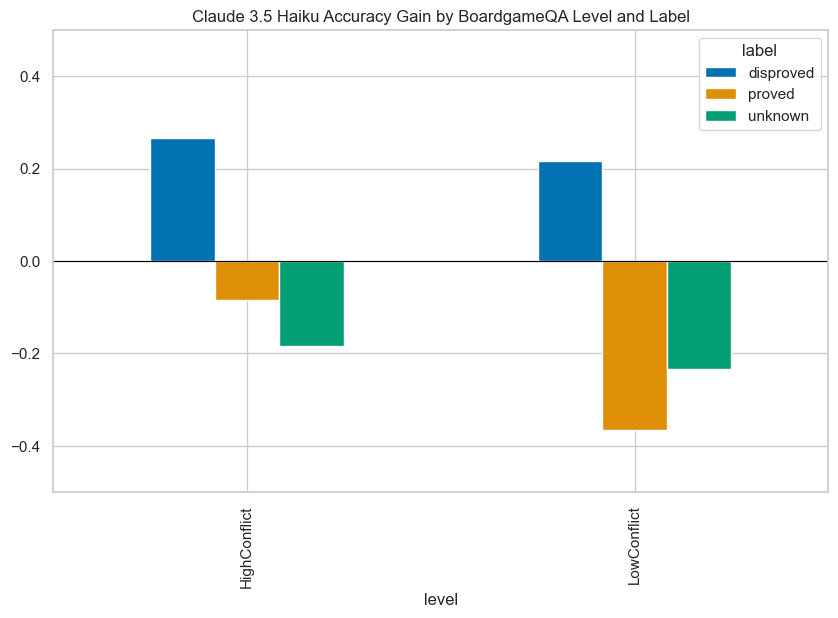

In [160]:
# Break down by level and label
level_label_results = answers_df.groupby(["level", "label"], as_index=False).agg(
    Count=("level", "count"),
    Baseline=("baseline", lambda x: (x == answers_df.loc[x.index, "label"]).mean()),
    Judge=("judge", lambda x: (x == answers_df.loc[x.index, "label"]).mean()),
)
level_label_results["Accuracy Gain"] = (
    level_label_results["Judge"] - level_label_results["Baseline"]
)

print("\nAccuracy by level and label:")
print(level_label_results.to_string(index=False))

level_label_results.pivot(index="level", columns="label", values="Accuracy Gain").plot(
    kind="bar",
    figsize=(10, 6),
    title="Claude 3.5 Haiku Accuracy Gain by BoardgameQA Level and Label",
    ylim=(-0.5, 0.5),
)
# Add a horizontal line at 0
plt.axhline(0, color="black", linewidth=0.8)
plt.show()

#### Testing for label bias

In [162]:
# # Do certain types of claims (proved/disproved/unknown) have systematically different success rates?
# # Perform statistical test to compare the accuracy of different labels
# alpha = 0.05
# print(f"\nSignificance level: {alpha}")

# for level in answers_df["level"].unique():


### Does the conflict level of scenarios affect judge accuracy independently of other factors?

In [163]:
# Does the conflict level of scenarios affect judge accuracy independently of other factors?


## Evidence Usage

### Does using more verified quotes lead to higher success rates in debates?

- Is the judge better at selecting debaters who use evidence more accurately?
- Does the relationship between quote accuracy and judge performance vary by conflict level?

All: Judge accuracy when its selected debater give:
 - more correct quotes than other: 37.80%
 - equal correct quotes as other : 40.56%
 - otherwise                     : 39.62%
Judge is not more likely to be correct when its selected debater gives more correct quotes
t-statistic: 0.582
p-value: 0.561
Fail to reject null hypothesis: accuracy difference is not significant

LowConflict: Judge accuracy when its selected debater gave:
 - more correct quotes than other: 44.44%
 - equal correct quotes as other : 38.83%
 - otherwise                     : 39.13%
t-statistic: 1.811
p-value: 0.072
Fail to reject null hypothesis: accuracy difference is not significant

HighConflict: Judge accuracy when its selected debater gave:
 - more correct quotes than other: 32.88%
 - equal correct quotes as other : 42.86%
 - otherwise                     : 40.00%
t-statistic: -0.860
p-value: 0.391
Fail to reject null hypothesis: accuracy difference is not significant


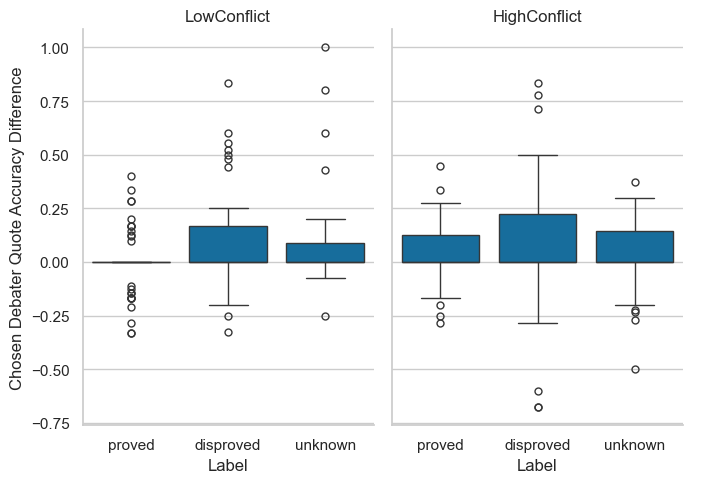

In [ ]:
from scipy import stats

# Calculate average accuracy for positive and negative chosen_debater_quote_acc_diff
pos_acc = (
    answers_df[answers_df["chosen_debater_quote_acc_diff"] > 0]["judge"]
    == answers_df[answers_df["chosen_debater_quote_acc_diff"] > 0]["label"]
)
eq_acc = (
    answers_df[answers_df["chosen_debater_quote_acc_diff"] == 0]["judge"]
    == answers_df[answers_df["chosen_debater_quote_acc_diff"] == 0]["label"]
)
neg_acc = (
    answers_df[answers_df["chosen_debater_quote_acc_diff"] < 0]["judge"]
    == answers_df[answers_df["chosen_debater_quote_acc_diff"] < 0]["label"]
)

print("All: Judge accuracy when its selected debater give:")
print(f" - more correct quotes than other: {pos_acc.mean():.2%}")
print(f" - equal correct quotes as other : {eq_acc.mean():.2%}")
print(f" - otherwise                     : {neg_acc.mean():.2%}")

if pos_acc.mean() > neg_acc.mean():
    print(
        "Judge is more likely to be correct when its selected debater gives more correct quotes"
    )
else:
    print(
        "Judge is not more likely to be correct when its selected debater gives more correct quotes"
    )

# Perform t-test between chosen_debater_quote_acc_diff for correct vs incorrect judgements
correct_diffs = answers_df[answers_df["judge"] == answers_df["label"]][
    "chosen_debater_quote_acc_diff"
]
incorrect_diffs = answers_df[answers_df["judge"] != answers_df["label"]][
    "chosen_debater_quote_acc_diff"
]
t_stat, p_value = stats.ttest_ind(correct_diffs, incorrect_diffs)

print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.3f}")
if p_value < alpha:
    print("Reject null hypothesis: accuracy difference is significant")
else:
    print("Fail to reject null hypothesis: accuracy difference is not significant")

# Calculate and print statistics by level
for level in answers_df["level"].unique():
    level_data = answers_df[answers_df["level"] == level]
    pos_acc = (
        level_data[level_data["chosen_debater_quote_acc_diff"] > 0]["judge"]
        == level_data[level_data["chosen_debater_quote_acc_diff"] > 0]["label"]
    )
    eq_acc = (
        level_data[level_data["chosen_debater_quote_acc_diff"] == 0]["judge"]
        == level_data[level_data["chosen_debater_quote_acc_diff"] == 0]["label"]
    )
    neg_acc = (
        level_data[level_data["chosen_debater_quote_acc_diff"] < 0]["judge"]
        == level_data[level_data["chosen_debater_quote_acc_diff"] < 0]["label"]
    )

    print(f"\n{level}: Judge accuracy when its selected debater gave:")
    print(f" - more correct quotes than other: {pos_acc.mean():.2%}")
    print(f" - equal correct quotes as other : {eq_acc.mean():.2%}")
    print(f" - otherwise                     : {neg_acc.mean():.2%}")

    # Perform t-test between chosen_debater_quote_acc_diff for correct vs incorrect judgements
    correct_diffs = level_data[level_data["judge"] == level_data["label"]][
        "chosen_debater_quote_acc_diff"
    ]
    incorrect_diffs = level_data[level_data["judge"] != level_data["label"]][
        "chosen_debater_quote_acc_diff"
    ]
    t_stat, p_value = stats.ttest_ind(correct_diffs, incorrect_diffs)

    print(f"t-statistic: {t_stat:.3f}")
    print(f"p-value: {p_value:.3f}")
    if p_value < alpha:
        print("Reject null hypothesis: accuracy difference is significant")
    else:
        print("Fail to reject null hypothesis: accuracy difference is not significant")

# Boxplots of chosen_debater_quote_acc_diff by label, faceted by level
g = sns.catplot(
    x="label",
    y="chosen_debater_quote_acc_diff",
    col="level",
    data=answers_df,
    kind="box",
    aspect=0.7,
)
g.set_axis_labels("Label", "Chosen Debater Quote Accuracy Difference")
g.set_titles("{col_name}")
plt.show()

### Is the judge better at selecting debaters who use evidence more accurately?

In [18]:
# Statistical test for scenario level bias
print("\nTesting for scenario level bias:")
contingency = pd.crosstab(
    answers_df["level"], answers_df["judge"] == answers_df["label"]
)
# Perform chi-square test
chi2, p_value = stats.chi2_contingency(contingency)[:2]
print("Contingency table:")
print(contingency)
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.4f}")


Testing for scenario level bias:
Contingency table:
col_0         False  True 
level                     
HighConflict    111     69
LowConflict     107     73
Chi-square statistic: 0.10
p-value: 0.7463


# Save cleaned version

In [20]:
# Save the results
answers_df.to_csv(result_path / "results.csv", index=False)